In [1]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
pd.set_option('display.max_columns', 100)

# Load and Clean Raw

In [2]:
def df_loader(csv_path):
    '''
    PARAMETERS
    ----------
    csv_path
        - str
        
    RETURNS
    -------
    df
        - pandas dataframe
    
    Loads up the raw data
    Expands the json columns
    Returns the df
    '''
    # Load
    convert_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    converters = {col: json.loads for col in convert_cols}
    df = pd.read_csv(csv_path, converters=converters, dtype={'fullVisitorId': 'str'})

    # json
    for col in convert_cols:
        df_col = json_normalize(df[col])
        df_col.columns = [f"{col}.{sub_col}" for sub_col in df_col.columns]
        df = df.drop(col, axis=1).merge(df_col, right_index=True, left_index=True)
    
    return df

In [3]:
# comment this out when not running

# df_train = df_loader('../data/train.csv') 
# print(df_train.shape)
# df_train.head()

(903653, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

This will be the first version of the cleaned data

In [7]:
# df_train.to_csv('../data/train_clean_v1.csv', index=False)

## Explore Revenue

In [3]:
dtypes = {'fullVisitorId': 'str', 'totals.transactionRevenue': 'float', 'trafficSource.campaignCode': 'str'}
df_train = pd.read_csv('../data/train_clean_v1.csv', dtype=dtypes)

Text(0.5,1,'Purchase of each Visit')

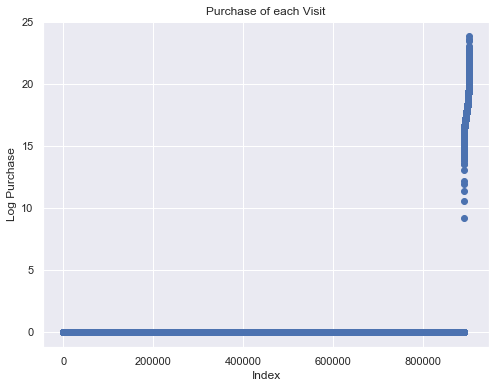

In [12]:
df_train['totals.transactionRevenue'].fillna(0, inplace=True)

vals = df_train['totals.transactionRevenue'].sort_values().values
vals = np.log1p(vals)

plt.figure(figsize=(8, 6))
plt.scatter(x=range(len(vals)), y=vals)
plt.xlabel('Index')
plt.ylabel('Log Purchase')
plt.title('Purchase of each Visit')

Most visits don't result in a purchase

## Exploring Single-Value and Null Columns

Validate columns with nulls and single-value columns. If they don't have much data that pertains to visits that resulted in a purchase then they'll likely get dropped. Notes on each column in question are below.

In [51]:
df_train.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                 

In [72]:
null_cols = df_train.columns[df_train.isna().any()].tolist()
sv_cols = [col for col in df_train.columns if df_train[col].nunique() == 1]

In [4]:
def col_looker(col):
    '''
    PARAMETERS:
    -----------
    col
        - str, the column to inspect
    
    
    Prints a written report of the percent of null values and single value
    between the purchasers and non-purchasers
    '''
    
    df_purch = df_train[df_train['totals.transactionRevenue'] > 0]
    df_no_purch = df_train[df_train['totals.transactionRevenue'] == 0]
    
    # Nulls
    purch_null = len(df_purch[df_purch[col].isnull()])
    purch_null = round(purch_null / len(df_purch), 2)
    no_purch_null = len(df_no_purch[df_no_purch[col].isnull()])
    no_purch_null = round(no_purch_null / len(df_no_purch), 2)

    print('-' * 50 + '\n' + col + '\n')
    print('Purchase % Null:\t', purch_null)
    print('No Purchase % Null:\t', no_purch_null)
    
    # Single Values
    if purch_null < 1:
        val = df_purch[col].value_counts().index[0]
        purch_sv = len(df_purch[df_purch[col] == val])
        purch_sv = round(purch_sv / len(df_purch), 2)
    else:
        val = 'N/A'
        purch_sv = 'N/A'
    print('Purchase % SV:\t\t', purch_sv)
    print(val)
    
    if no_purch_null < 1:
        val = df_no_purch[col].value_counts().index[0]
        no_purch_sv = len(df_no_purch[df_no_purch[col] == val])
        no_purch_sv = round(no_purch_sv / len(df_no_purch), 2)
    else:
        val = 'N/A'
        no_purch_sv = 'N/A'
    print('No Purchase % SV:\t', no_purch_sv)
    print(val)

In [97]:
cols_to_check = [col for col in df_train.columns if col in set(null_cols + sv_cols)]
for col in cols_to_check:
    col_looker(col)

--------------------------------------------------
socialEngagementType

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
Not Socially Engaged
No Purchase % SV:	 1.0
Not Socially Engaged
--------------------------------------------------
device.browserSize

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
not available in demo dataset
No Purchase % SV:	 1.0
not available in demo dataset
--------------------------------------------------
device.browserVersion

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
not available in demo dataset
No Purchase % SV:	 1.0
not available in demo dataset
--------------------------------------------------
device.flashVersion

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
not available in demo dataset
No Purchase % SV:	 1.0
not available in demo dataset
--------------------------------------------------
device.language

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase 

### Notes on Columns

* socialEngagementType
    * **dropping** - just the same value
* device.browserSize
    * **dropping** - just the same value
* device.browserVersion
    * **dropping** - just the same value
* device.flashVersion
    * **dropping** - just the same value
* device.language
    * **dropping** - just the same value
* device.mobileDeviceBranding
    * **dropping** - just the same value
* device.mobileDeviceInfo
    * **dropping** - just the same value
* device.mobileDeviceMarketingName
    * **dropping** - just the same value
* device.mobileDeviceModel
    * **dropping** - just the same value
* device.mobileInputSelector
    * **dropping** - just the same value
* device.operatingSystemVersion
    * **dropping** - just the same value
* device.screenColors
    * **dropping** - just the same value
* device.screenResolution
    * **dropping** - just the same value
* geoNetwork.cityId
    * **dropping** - just the same value
* geoNetwork.latitude
    * **dropping** - just the same value
* geoNetwork.longitude
    * **dropping** - just the same value
* geoNetwork.networkLocation
    * **dropping** - just the same value
* totals.bounces
    * **keeping** - boolean impute 0, no one who purchases bounces, this could be a good predictor for no purchase
* totals.newVisits
    * **dropping** - was going to keep as missing values indicate revisit but this info is kept in visitNumber
* totals.pageviews
    * **keeping** - over half of values are 1, imputing as such. Most pageviews are higher for 
        those who purchase so likely a good predictor
* totals.visits
    * **dropping** - just the same value
* trafficSource.adContent
    * **dropping** - missing most data and what's available is *not* helpful
* trafficSource.adwordsClickInfo.adNetworkType
    * **dropping** - missing most data and what's available is *not* helpful
* trafficSource.adwordsClickInfo.criteriaParameters
    * **dropping** - just the same value
* trafficSource.adwordsClickInfo.gclId
    * **dropping** - missing most data and what's available is *not* helpful
* trafficSource.adwordsClickInfo.isVideoAd
    * **dropping** - missing most data and what's available is *not* helpful
* trafficSource.adwordsClickInfo.page
    * **dropping** - missing most data
* trafficSource.adwordsClickInfo.slot
    * **dropping** - missing most data and what's available is *not* helpful
* trafficSource.campaignCode
    * **dropping** - missing all but one data point
* trafficSource.isTrueDirect
    * **keeping** - boolean, impute value of False for missing values
* trafficSource.keyword
    * **dropping** - missing most data and what's available is *not* helpful
* trafficSource.referralPath
    * **dropping** - missing most data and what's available is *not* helpful

In [63]:
drop_cols = [
    'socialEngagementType',
    'device.browserSize',
    'device.browserVersion',
    'device.flashVersion',
    'device.language',
    'device.mobileDeviceBranding',
    'device.mobileDeviceInfo',
    'device.mobileDeviceMarketingName',
    'device.mobileDeviceModel',
    'device.mobileInputSelector',
    'device.operatingSystemVersion',
    'device.screenColors',
    'device.screenResolution',
    'geoNetwork.cityId',
    'geoNetwork.latitude',
    'geoNetwork.longitude',
    'geoNetwork.networkLocation',
    'totals.newVisits',
    'totals.visits',
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.criteriaParameters',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaignCode',
    'trafficSource.keyword',
    'trafficSource.referralPath'
]

---
## Explore Last Columns
Now that the obvious columns are looked at, we'll look at the rest of the columns here as we make decisions on imputing/feature generation.

In [13]:
df_purch = df_train[df_train['totals.transactionRevenue'] > 0]
df_no_purch = df_train[df_train['totals.transactionRevenue'] == 0]

In [36]:
def col_explore(col):
    '''
    Prints the sorted values counts percentages between those who purchase and those who don't for the input column
    '''
    print('-' * 50 + '\n' + 'Purchase' + '\n')
    purch_series = df_purch[col].value_counts().sort_index() / len(df_purch)
    print(purch_series.round(3))
    print('-' * 50 + '\n' + 'No Purchase' + '\n')
    no_purch_series = df_no_purch[col].value_counts().sort_index() / len(df_no_purch)
    print(no_purch_series.round(3))

#### channelGrouping
If they are referred then there's a better chance they'll purchase. Not a lot of social channels end up in purchase. Organic doeesn't differ much. 

Turn into at least one boolean but maybe 2:
* is_referred_channel
* is_social_channel

In [37]:
col_explore('channelGrouping')

--------------------------------------------------
Purchase

(Other)           0.000
Affiliates        0.001
Direct            0.177
Display           0.012
Organic Search    0.299
Paid Search       0.041
Referral          0.461
Social            0.009
Name: channelGrouping, dtype: float64
--------------------------------------------------
No Purchase

(Other)           0.000
Affiliates        0.018
Direct            0.158
Display           0.007
Organic Search    0.424
Paid Search       0.028
Referral          0.112
Social            0.253
Name: channelGrouping, dtype: float64


#### date
Will convert to datetime with the format %Y%m%d

#### fullVisitorId
Keeping, duh

#### sessionId
unique visit id, keeping

#### visitId
**dropping**, similar to sessionid

#### visitNumber
Visit number, keep

#### visitStartTime
Just unique vals, no end time. Will convert from UNIX time to hours of day, might be useful info between those who visited during normal business hours.

In [38]:
perc = round(df_train['visitStartTime'].nunique() / len(df_train), 3) * 100
print(f'Percent of unique values: {perc}%')

Percent of unique values: 98.2%


#### device.browser
Turn this into a boolean column of purchase made from Chrome or not

In [39]:
col_explore('device.browser')

--------------------------------------------------
Purchase

Amazon Silk          0.000
Android Webview      0.001
Chrome               0.899
Edge                 0.005
Firefox              0.017
Internet Explorer    0.009
Opera                0.000
Safari               0.068
Safari (in-app)      0.001
Name: device.browser, dtype: float64
--------------------------------------------------
No Purchase

(not set)                                      0.000
0                                              0.000
ADM                                            0.000
Amazon Silk                                    0.001
Android Browser                                0.001
Android Runtime                                0.000
Android Webview                                0.009
Apple-iPhone7C2                                0.000
BlackBerry                                     0.000
CSM Click                                      0.000
Changa 99695759                                0.000
Chrome      

#### device.deviceCategory
Normally, this would become a boolean of from desktop or not, but device.isMobile does that so this column will be **dropped**. See next block for details.

In [40]:
col_explore('device.deviceCategory')

--------------------------------------------------
Purchase

desktop    0.911
mobile     0.074
tablet     0.015
Name: device.deviceCategory, dtype: float64
--------------------------------------------------
No Purchase

desktop    0.733
mobile     0.233
tablet     0.034
Name: device.deviceCategory, dtype: float64


#### device.isMobile
Keep, should turn into 0 and 1

In [41]:
col_explore('device.isMobile')

--------------------------------------------------
Purchase

False    0.911
True     0.089
Name: device.isMobile, dtype: float64
--------------------------------------------------
No Purchase

False    0.733
True     0.267
Name: device.isMobile, dtype: float64


#### device.operatingSystem
Tempted to turn this into three boolean columns but may just stick with one - the first one:
* is_chrome_os
* is_mac_os
* is_windows_os

In [42]:
col_explore('device.operatingSystem')

--------------------------------------------------
Purchase

Android          0.041
Chrome OS        0.086
Linux            0.068
Macintosh        0.558
Windows          0.201
Windows Phone    0.000
iOS              0.047
Name: device.operatingSystem, dtype: float64
--------------------------------------------------
No Purchase

(not set)        0.005
Android          0.138
BlackBerry       0.000
Chrome OS        0.028
Firefox OS       0.000
FreeBSD          0.000
Linux            0.038
Macintosh        0.277
NTT DoCoMo       0.000
Nintendo 3DS     0.000
Nintendo Wii     0.000
Nintendo WiiU    0.000
Nokia            0.000
OpenBSD          0.000
Samsung          0.000
SunOS            0.000
Windows          0.390
Windows Phone    0.001
Xbox             0.000
iOS              0.120
Name: device.operatingSystem, dtype: float64


#### geoNetwork.city
Perhaps this could have some value if it was processed by region but the value in that data doesn't likely warrant the effort, hopefully other columns capture this to some degree.

In [43]:
col_explore('geoNetwork.city')

--------------------------------------------------
Purchase

(not set)                        0.004
Ahmedabad                        0.000
Amsterdam                        0.000
Ann Arbor                        0.017
Athens                           0.000
Atlanta                          0.009
Atwater                          0.000
Austin                           0.018
Bangkok                          0.000
Barcelona                        0.000
Barrie                           0.000
Bellevue                         0.000
Bengaluru                        0.000
Berkeley                         0.000
Berlin                           0.000
Bogota                           0.000
Boston                           0.001
Bothell                          0.000
Boulder                          0.002
Bucharest                        0.000
Buenos Aires                     0.000
Calgary                          0.000
Cambridge                        0.010
Charlotte                        0.001
Chi

#### geoNetwork.continent

Only 2% of purchases are made outside of the Americas so that's a solid indicator of purchase

In [44]:
col_explore('geoNetwork.continent')

--------------------------------------------------
Purchase

(not set)    0.001
Africa       0.001
Americas     0.980
Asia         0.011
Europe       0.007
Oceania      0.001
Name: geoNetwork.continent, dtype: float64
--------------------------------------------------
No Purchase

(not set)    0.002
Africa       0.017
Americas     0.492
Asia         0.251
Europe       0.222
Oceania      0.017
Name: geoNetwork.continent, dtype: float64


#### geoNetwork.country
Just like the city data, too granular. Continent does the job.

In [45]:
col_explore('geoNetwork.country')

--------------------------------------------------
Purchase

(not set)               0.001
Anguilla                0.000
Argentina               0.000
Armenia                 0.000
Australia               0.001
Belgium                 0.000
Brazil                  0.001
Canada                  0.017
Chile                   0.000
China                   0.001
Colombia                0.001
Curaçao                 0.000
Cyprus                  0.000
Czechia                 0.000
Denmark                 0.000
Ecuador                 0.000
Egypt                   0.000
El Salvador             0.000
Finland                 0.000
France                  0.000
Georgia                 0.000
Germany                 0.001
Greece                  0.000
Guadeloupe              0.000
Guatemala               0.000
Hong Kong               0.001
Hungary                 0.000
India                   0.001
Indonesia               0.001
Ireland                 0.001
                        ...  
Netherlan

#### geoNetwork.metro
Just like the city and country data, too granular. Continent does the job.

In [46]:
col_explore('geoNetwork.metro')

--------------------------------------------------
Purchase

(not set)                             0.023
Atlanta GA                            0.009
Austin TX                             0.018
Baltimore MD                          0.000
Boston MA-Manchester NH               0.012
Charleston SC                         0.000
Charlotte NC                          0.001
Chicago IL                            0.037
Cincinnati OH                         0.000
Columbus OH                           0.000
Dallas-Ft. Worth TX                   0.002
Denver CO                             0.003
Detroit MI                            0.017
El Paso TX                            0.000
Fresno-Visalia CA                     0.000
Hartford & New Haven CT               0.000
Houston TX                            0.005
Indianapolis IN                       0.000
Jacksonville FL                       0.000
Kansas City MO                        0.000
Las Vegas NV                          0.000
London         

#### geoNetwork.networkDomain
Doesn't look particularly interesting

In [47]:
col_explore('geoNetwork.networkDomain')

--------------------------------------------------
Purchase

(not set)                  0.577
111-tataidc.co.in          0.000
123.net                    0.000
150pelican.com             0.000
295.ca                     0.000
2uibe.com                  0.000
3bb.co.th                  0.000
5ninesdata.com             0.000
abb.com                    0.000
abbott.com                 0.000
above.net                  0.000
acadian.com                0.000
accesscomm.ca              0.000
accesskenya.com            0.000
acgtexas.com               0.000
acsalaska.net              0.000
aemedia.us                 0.000
afop.com                   0.000
agosto.com                 0.000
airstreamcomm.net          0.000
airtelbroadband.in         0.000
akqa.com                   0.000
alamancecounty-ymca.org    0.000
algx.net                   0.000
allcareipa.com             0.000
allis-roller.com           0.000
allstream.net              0.000
alshamil.net.ae            0.000
alter.net      

#### geoNetwork.region
Just like the city, country, and metro data - too granular. Continent does the job.

In [48]:
col_explore('geoNetwork.region')

--------------------------------------------------
Purchase

(not set)                            0.004
Alberta                              0.000
Arizona                              0.001
Attica                               0.000
Bangkok                              0.000
Berlin                               0.000
Bogota                               0.000
British Columbia                     0.000
Bucharest                            0.000
Buenos Aires                         0.000
California                           0.287
Catalonia                            0.000
Colorado                             0.003
Connecticut                          0.000
County Dublin                        0.000
Delhi                                0.000
District of Columbia                 0.009
Dubai                                0.000
Dublin City                          0.000
England                              0.001
Federal Territory of Kuala Lumpur    0.000
Florida                             

#### geoNetwork.subContinent
Just like the city, country, metro, and region data - too granular. Continent does the job.

In [49]:
col_explore('geoNetwork.subContinent')

--------------------------------------------------
Purchase

(not set)           0.001
Australasia         0.001
Caribbean           0.001
Central America     0.002
Central Asia        0.000
Eastern Africa      0.000
Eastern Asia        0.005
Eastern Europe      0.001
Northern Africa     0.000
Northern America    0.968
Northern Europe     0.002
South America       0.009
Southeast Asia      0.003
Southern Africa     0.000
Southern Asia       0.001
Southern Europe     0.001
Western Africa      0.000
Western Asia        0.002
Western Europe      0.003
Name: geoNetwork.subContinent, dtype: float64
--------------------------------------------------
No Purchase

(not set)             0.002
Australasia           0.017
Caribbean             0.003
Central America       0.017
Central Asia          0.001
Eastern Africa        0.002
Eastern Asia          0.053
Eastern Europe        0.051
Melanesia             0.000
Micronesian Region    0.000
Middle Africa         0.000
Northern Africa       0.009

#### totals.hits
Not a lot here but no one makes a purchase on 1 hit so transform into a boolean of 1 hit or not

In [50]:
col_explore('totals.hits')

--------------------------------------------------
Purchase

2      0.000
3      0.000
4      0.001
5      0.001
6      0.001
7      0.002
8      0.005
9      0.008
10     0.011
11     0.017
12     0.022
13     0.027
14     0.030
15     0.031
16     0.031
17     0.030
18     0.033
19     0.030
20     0.029
21     0.027
22     0.025
23     0.027
24     0.025
25     0.023
26     0.024
27     0.023
28     0.023
29     0.019
30     0.023
31     0.018
       ...  
209    0.000
210    0.000
216    0.000
218    0.000
220    0.000
227    0.000
229    0.000
237    0.000
238    0.000
243    0.000
246    0.000
268    0.000
278    0.000
279    0.000
286    0.000
292    0.000
308    0.000
311    0.000
328    0.000
331    0.000
347    0.000
361    0.000
378    0.000
382    0.000
385    0.000
386    0.000
387    0.000
445    0.000
471    0.000
500    0.000
Name: totals.hits, Length: 215, dtype: float64
--------------------------------------------------
No Purchase

1      0.501
2      0.155
3      0.

#### trafficSource.campaign
Nothing meaningful here **dropping**

In [52]:
col_explore('trafficSource.campaign')

--------------------------------------------------
Purchase

(not set)                                          0.960
AW - Accessories                                   0.011
AW - Apparel                                       0.000
AW - Dynamic Search Ads Whole Site                 0.028
Data Share Promo                                   0.001
Retail (DO NOT EDIT owners nophakun and tianyu)    0.000
test-liyuhz                                        0.000
Name: trafficSource.campaign, dtype: float64
--------------------------------------------------
No Purchase

(not set)                                          0.958
AW - Accessories                                   0.008
AW - Apparel                                       0.000
AW - Dynamic Search Ads Whole Site                 0.016
AW - Electronics                                   0.000
All Products                                       0.000
Data Share                                         0.000
Data Share Promo                

#### trafficSource.medium
Pretty similar data as in channelGrouping, **dropping**

In [53]:
col_explore('trafficSource.medium')

--------------------------------------------------
Purchase

(none)       0.177
(not set)    0.000
affiliate    0.001
cpc          0.041
cpm          0.012
organic      0.299
referral     0.470
Name: trafficSource.medium, dtype: float64
--------------------------------------------------
No Purchase

(none)       0.158
(not set)    0.000
affiliate    0.018
cpc          0.028
cpm          0.007
organic      0.424
referral     0.365
Name: trafficSource.medium, dtype: float64


#### trafficSource.source
Nothing interesting here, **dropping**

In [54]:
col_explore('trafficSource.source')

--------------------------------------------------
Purchase

(direct)                     0.177
Partners                     0.001
ask                          0.000
basecamp.com                 0.000
bing                         0.002
calendar.google.com          0.000
chat.google.com              0.000
connect.googleforwork.com    0.000
dealspotr.com                0.003
dfa                          0.011
docs.google.com              0.000
duckduckgo.com               0.000
facebook.com                 0.002
gatewaycdi.com               0.000
gdeals.googleplex.com        0.002
google                       0.337
google.com                   0.000
googleux.perksplus.com       0.000
groups.google.com            0.003
keep.google.com              0.000
l.facebook.com               0.001
l.messenger.com              0.000
m.facebook.com               0.001
mail.aol.com                 0.000
mail.google.com              0.005
mall.googleplex.com          0.443
mg.mail.yahoo.com            